In [102]:
import os
import glob
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from orca.transform import imaging, peeling, dada2ms
from orca.metadata.pathsmanagers import OfflinePathsManager
from astropy.io import fits
from astropy.wcs import WCS
import casatools as tools

In [85]:
age = 1 # hours
duration = 13 # seconds
spw = '21'  # 

In [86]:
now = datetime.now()
start_time = now.replace(hour=now.hour-age)
end_time = start_time + timedelta(seconds=duration)

In [87]:
buffer = '7day_buffer'  # choose a buffer

#outdir = '/lustre/claw/{0}'.format(start_time.strftime("%y%m%d"))
outdir = '/lustre/claw/'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [88]:
pm = OfflinePathsManager(utc_times_txt_path='/lustre/data/7day_buffer/utc_times.txt', 
                         dadafile_dir='/lustre/data/{0}'.format(buffer), 
                         msfile_dir=outdir,
                         bcal_dir='/lustre/mmanders/bufferdata/hourly/BCAL_stripe3',
                         flag_npy_path='/home/yuping/100-hr-a-priori-flags/20191125-consolidated-flags/20191125-consolidated-flags.npy')

In [89]:
for time in pm.utc_times_mapping: 
    if start_time <= time < end_time:
        print("Converting to MS for time {0}, spw {1}".format(time, spw))
        dada2ms.run_dada2ms(dada_file=pm.get_dada_path(spw, time), out_ms=pm.get_ms_path(time, spw), gaintable=pm.get_gaintable_path(spw)) 
        msfiles = glob.glob(pm.msfile_dir + start_time.strftime("%Y-%m-%d") + '/*/*/*ms') 
        print("Iterating over msfiles: ", msfiles)
        for msfile in msfiles: 
            print("\t Peel and image ", msfile)
#            peeling.peel_with_ttcal(msfile, '/home/claw/code/calim-pipeline-phase2/sources.json') 
            imaging.make_image([msfile], date_times_string=start_time.strftime("%Y-%m-%d"),
                               out_dir=pm.msfile_dir + start_time.strftime("%Y-%m-%d"))

Converting to MS for time 2019-12-10 09:26:53, spw 21
Iterating over msfiles:  ['/lustre/claw/2019-12-10/hh=09/2019-12-10T09:26:53/21_2019-12-10T09:26:53.ms', '/lustre/claw/2019-12-10/hh=08/2019-12-10T08:36:37/21_2019-12-10T08:36:37.ms']
	 Peel and image  /lustre/claw/2019-12-10/hh=09/2019-12-10T09:26:53/21_2019-12-10T09:26:53.ms
	 Peel and image  /lustre/claw/2019-12-10/hh=08/2019-12-10T08:36:37/21_2019-12-10T08:36:37.ms


In [120]:
fitsfile = pm.msfile_dir + start_time.strftime("%Y-%m-%d") + '/' + start_time.strftime("%Y-%m-%d") + '-image.fits'
hdu = fits.open(fitsfile)
wcs = WCS(hdu[0].header, naxis=2)
image = hdu[0].data.squeeze()

## Image check

In [173]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 89.34634  37.05505  
CRPIX : 2049.0  2049.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.03125  0.03125  
NAXIS : 4096  4096  1  1

Image ranges from -132.9811248779297 to 1264.8763427734375


/home/claw/.conda/envs/py3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/home/claw/.conda/envs/py3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/home/claw/.conda/envs/py3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/home/claw/.conda/envs/py3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/home/claw/.conda/envs/py3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in grea

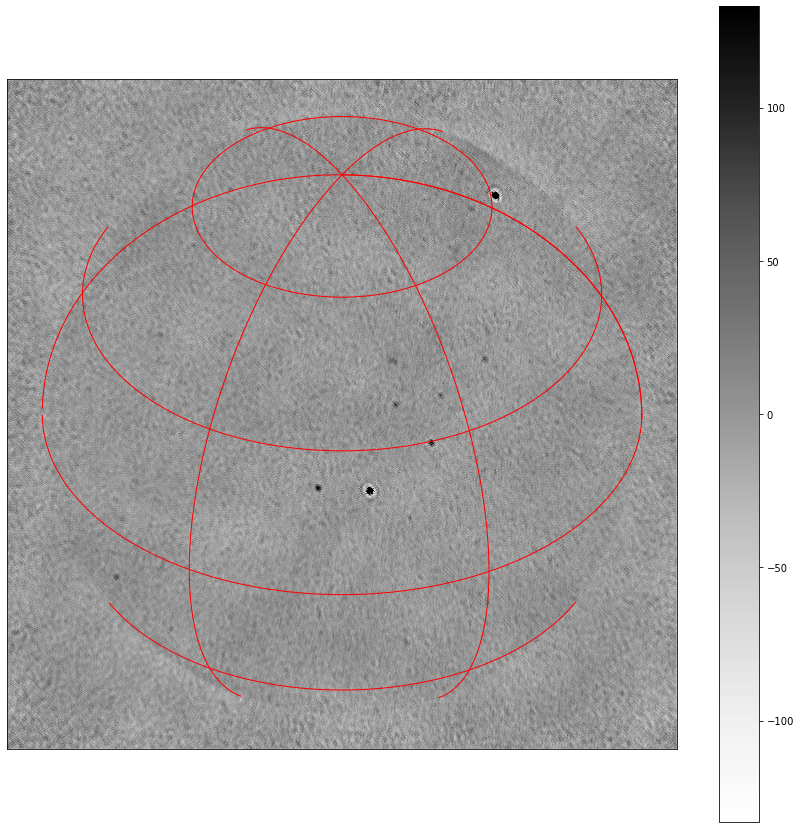

In [184]:
fig, ax = plt.subplots(figsize=(15,15), subplot_kw={'projection': wcs})
ax.grid(b=True, linewidth=1, color='r')
#xticklocations = np.arange(-np.pi+30.*(np.pi/180.), np.pi, 30.*(np.pi/180.))
#xticklabels = [r"{0:d}".format(ang) for ang in np.arange(330,0,-30)]
#ax.set_xticks(xticklocations)
#ax.set_xticklabels(xticklabels)

scale = np.abs(image.min())
print("Image ranges from {0} to {1}".format(image.min(), image.max()))
im = ax.imshow(image, vmin=-scale, vmax=scale, cmap='Greys')
plt.xlabel("RA")
cb = fig.colorbar(im)

## Visibility data check

In [188]:
ms = tools.ms()
ms.open(msfile)
ms.summary()
getdata = ms.getdata(['data', 'data_desc_id', 'axis_info'], ifraxis=True)
data = getdata['data']
npol, nchan, nbl = data.shape

In [208]:
getdata['axis_info']

{'corr_axis': array(['XX', 'XY', 'YX', 'YY'], dtype='<U16'),
 'freq_axis': {'chan_freq': array([[82320000.],
         [82344000.],
         [82368000.],
         [82392000.],
         [82416000.],
         [82440000.],
         [82464000.],
         [82488000.],
         [82512000.],
         [82536000.],
         [82560000.],
         [82584000.],
         [82608000.],
         [82632000.],
         [82656000.],
         [82680000.],
         [82704000.],
         [82728000.],
         [82752000.],
         [82776000.],
         [82800000.],
         [82824000.],
         [82848000.],
         [82872000.],
         [82896000.],
         [82920000.],
         [82944000.],
         [82968000.],
         [82992000.],
         [83016000.],
         [83040000.],
         [83064000.],
         [83088000.],
         [83112000.],
         [83136000.],
         [83160000.],
         [83184000.],
         [83208000.],
         [83232000.],
         [83256000.],
         [83280000.],
         [8

In [225]:
ifr_name = getdata['axis_info']['ifr_axis']['ifr_name']
baseline = getdata['axis_info']['ifr_axis']['baseline']

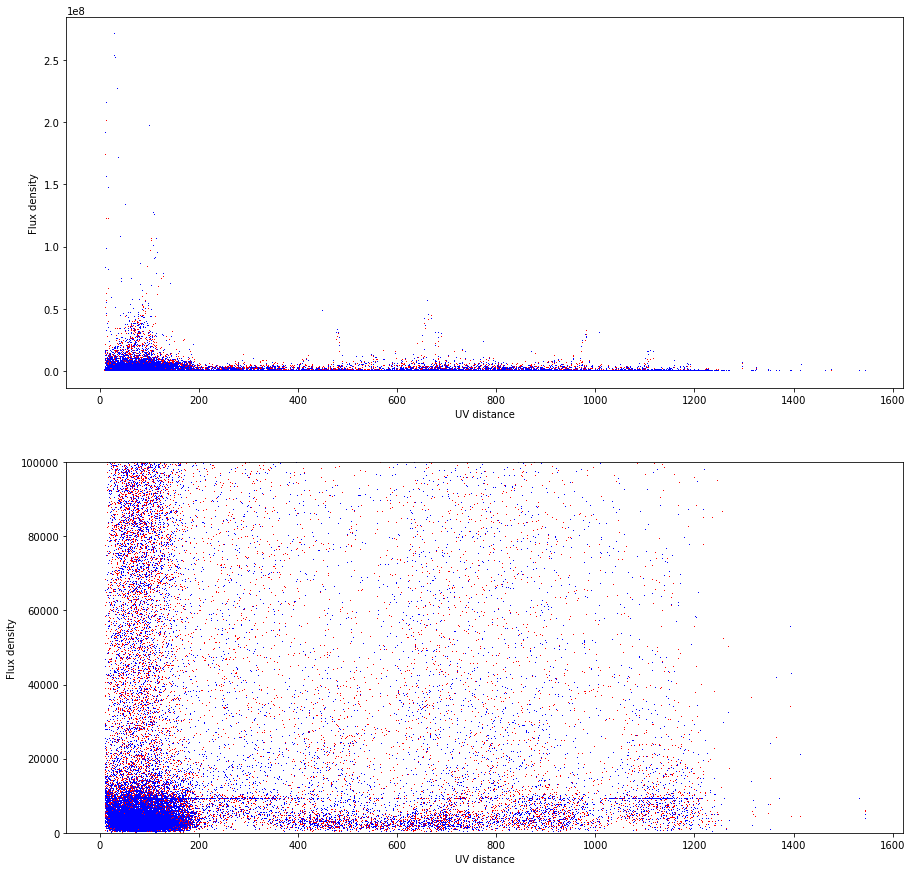

In [254]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(15,15))
sel = np.where(baseline > 10)[0]
ax0.plot(baseline[sel], np.abs(data[0,0,sel]), 'r,')
ax0.plot(baseline[sel], np.abs(data[3,0,sel]), 'b,')
_ = ax0.set_xlabel("UV distance")
_ = ax0.set_ylabel("Flux density")

ax1.plot(baseline[sel], np.abs(data[0,0,sel]), 'r,')
ax1.plot(baseline[sel], np.abs(data[3,0,sel]), 'b,')
ax1.set_ylim(0, 1e5)
_ = ax1.set_xlabel("UV distance")
_ = ax1.set_ylabel("Flux density")

In [234]:
arr = np.zeros((256, 256), dtype=float)
for i, ifr in enumerate(ifr_name):
    ant1n, ant2n = ifr.split('-')
    ant1 = int(ant1n.lstrip("ANT"))
    ant2 = int(ant2n.lstrip("ANT"))
    arr[ant1-1, ant2-1] = data[0,0,i]

/home/claw/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


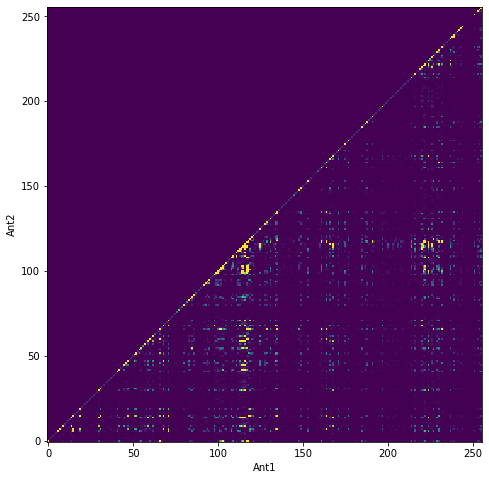

In [256]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(arr, origin='bottom', vmin=1e3, vmax=1e7)
_ = ax.set_xlabel("Ant1")
_ = ax.set_ylabel("Ant2")